In [2]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Conv2DTranspose, Conv2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

# Load the MNIST data
We want to generate numbers and we dont care which number. Therefor we olny want the training images

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64)

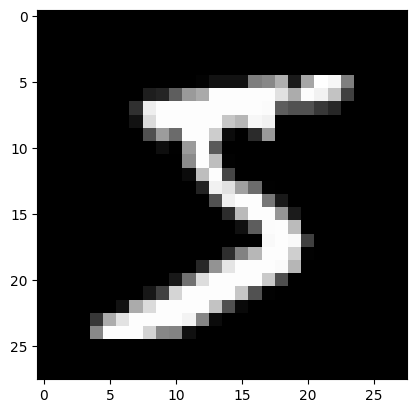

In [8]:
for batch in train_dataset:
    plt.imshow(batch[0], cmap='gray')
    break

# Generator model

In [35]:
def build_generator(noise_dim):
    model = Sequential()

    model.add(Dense(64 * 7 * 7, activation="relu", input_dim=noise_dim))
    model.add(Reshape((7, 7, 64)))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2D(1, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))

    return model

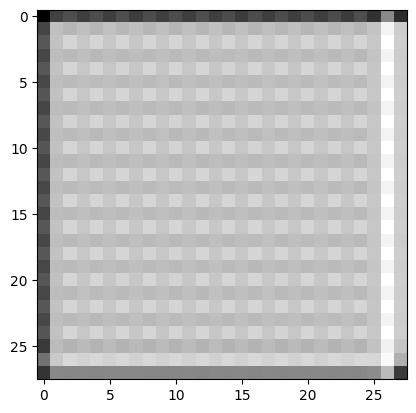

In [36]:
generator = build_generator(20)

noise = tf.random.normal([1, 20])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap='gray')

In [37]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Dicriminator model

In [38]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [39]:
discriminator = build_discriminator((28,28,1))
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.51381755]], shape=(1, 1), dtype=float32)


# Loss functions and optimizers

In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [41]:
# We create the labels in the loss function.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [42]:
def generator_loss(fake_output):
    # We want the dicriminator to think all fake images are correct.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the models

In [44]:
@tf.function
def train_step(images, noise_dim):
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Set batchsize and number of generated exampels to the same number
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [45]:
def show_generated_image(generator, noise_dim):
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate an image from the noise
    generated_image = generator.predict(noise)[0]

    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [46]:
def train(dataset, epochs, noise_dim):
    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            train_step(image_batch, noise_dim)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        # Show generated image
        show_generated_image(generator, noise_dim)


c:\Users\hakan\.virtualenvs\Deep-Learning-Zv8C6_EQ\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 28.195026636123657 sec
1/1 [==============================] - 0s 115ms/step


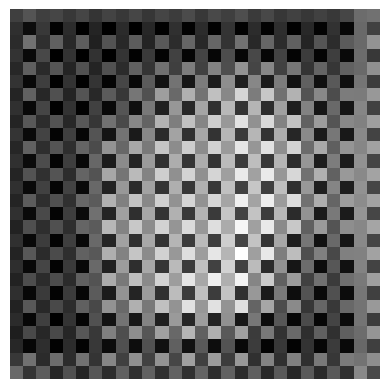

Time for epoch 2 is 28.15656018257141 sec
1/1 [==============================] - 0s 17ms/step


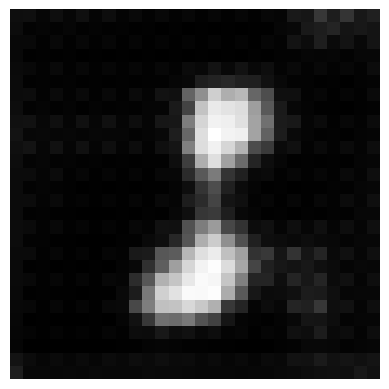

Time for epoch 3 is 26.823684453964233 sec
1/1 [==============================] - 0s 18ms/step


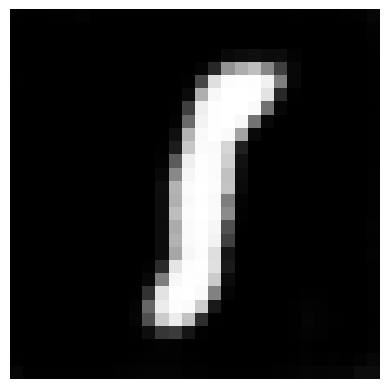

Time for epoch 4 is 26.96989345550537 sec
1/1 [==============================] - 0s 22ms/step


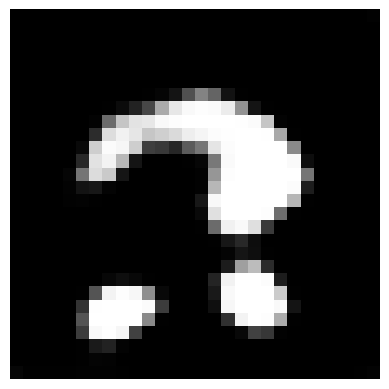

Time for epoch 5 is 26.805135011672974 sec
1/1 [==============================] - 0s 21ms/step


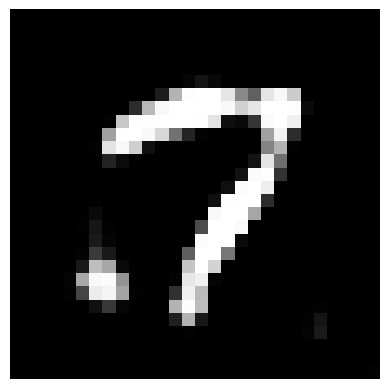

Time for epoch 6 is 27.132635831832886 sec
1/1 [==============================] - 0s 18ms/step


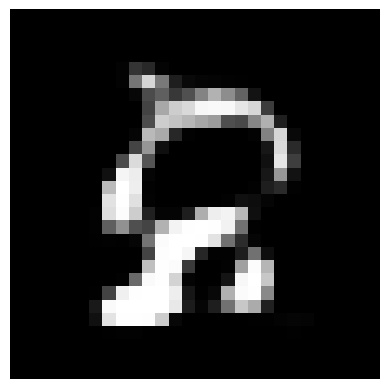

Time for epoch 7 is 29.342834949493408 sec
1/1 [==============================] - 0s 20ms/step


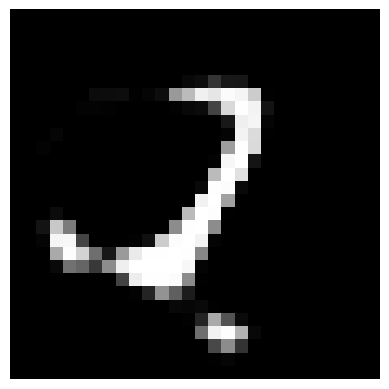

Time for epoch 8 is 26.75125503540039 sec
1/1 [==============================] - 0s 20ms/step


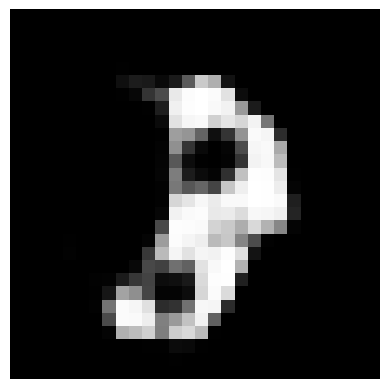

Time for epoch 9 is 26.901509046554565 sec
1/1 [==============================] - 0s 18ms/step


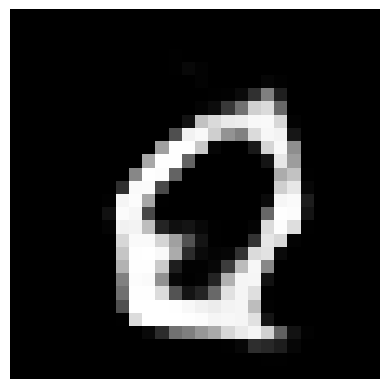

Time for epoch 10 is 26.971976041793823 sec
1/1 [==============================] - 0s 20ms/step


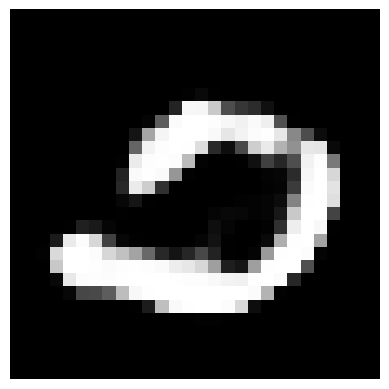

Time for epoch 11 is 30.280155658721924 sec
1/1 [==============================] - 0s 24ms/step


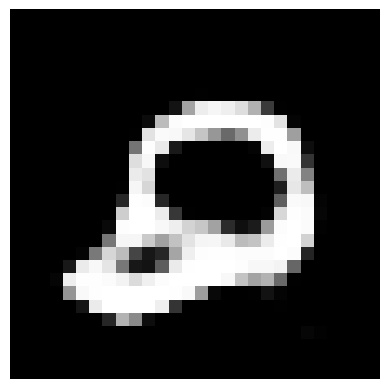

Time for epoch 12 is 27.931259632110596 sec
1/1 [==============================] - 0s 23ms/step


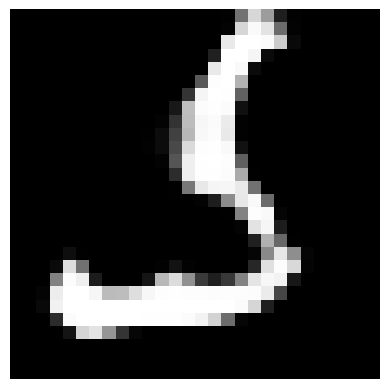

Time for epoch 13 is 33.06524038314819 sec
1/1 [==============================] - 0s 18ms/step


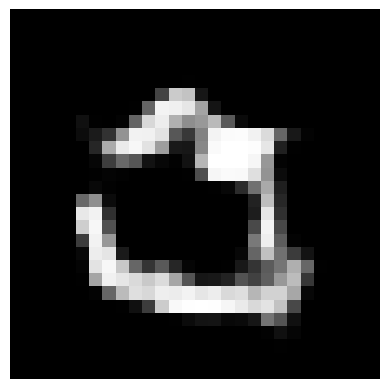

Time for epoch 14 is 29.900693893432617 sec
1/1 [==============================] - 0s 23ms/step


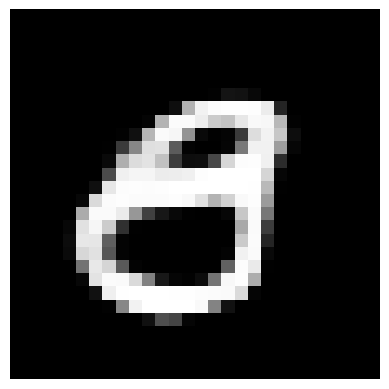

Time for epoch 15 is 26.41360878944397 sec
1/1 [==============================] - 0s 16ms/step


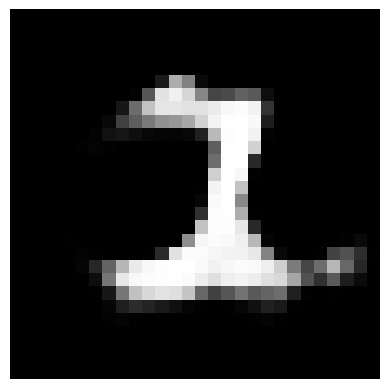

Time for epoch 16 is 27.453307628631592 sec
1/1 [==============================] - 0s 17ms/step


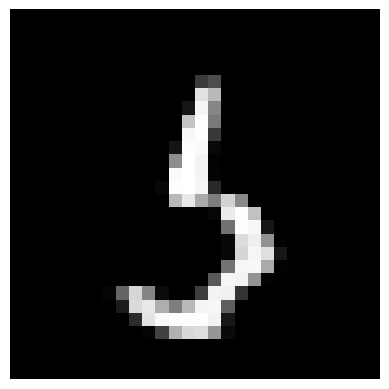

Time for epoch 17 is 29.032713413238525 sec
1/1 [==============================] - 0s 36ms/step


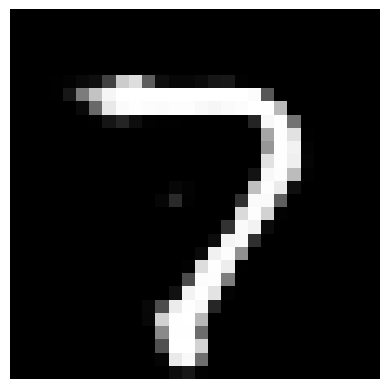

Time for epoch 18 is 29.27675461769104 sec
1/1 [==============================] - 0s 21ms/step


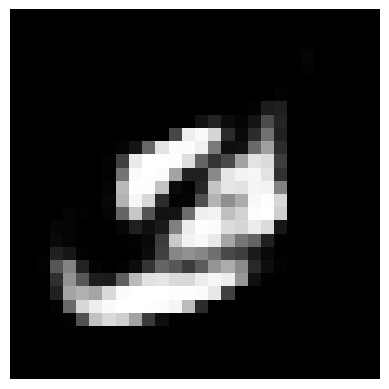

Time for epoch 19 is 29.506552934646606 sec
1/1 [==============================] - 0s 19ms/step


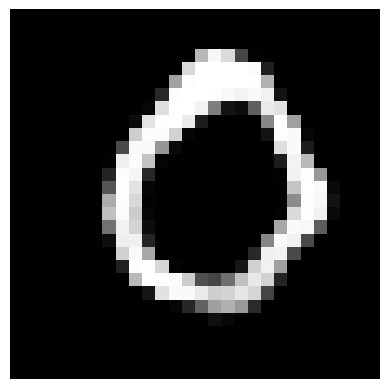

Time for epoch 20 is 30.72004747390747 sec
1/1 [==============================] - 0s 27ms/step


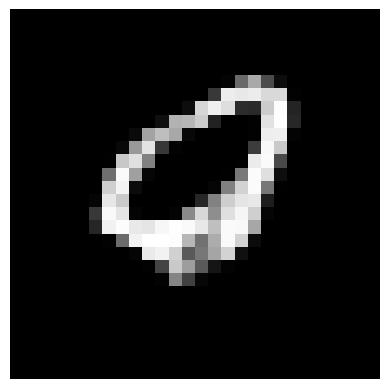

Time for epoch 21 is 29.13806653022766 sec
1/1 [==============================] - 0s 17ms/step


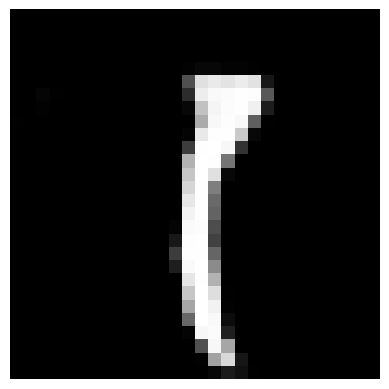

Time for epoch 22 is 28.80632257461548 sec
1/1 [==============================] - 0s 17ms/step


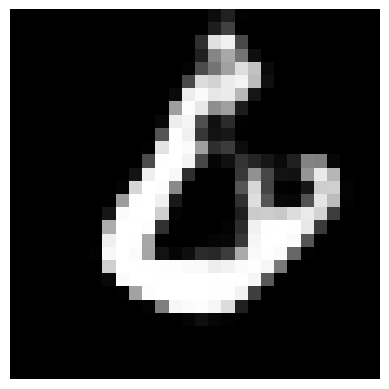

Time for epoch 23 is 28.960375785827637 sec
1/1 [==============================] - 0s 22ms/step


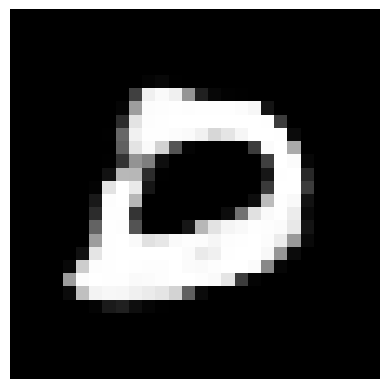

Time for epoch 24 is 29.920398950576782 sec
1/1 [==============================] - 0s 19ms/step


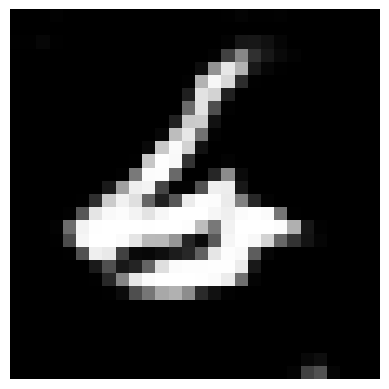

Time for epoch 25 is 29.586430549621582 sec
1/1 [==============================] - 0s 22ms/step


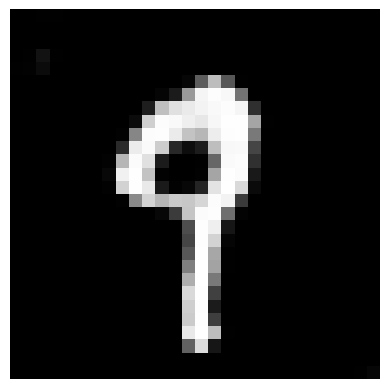

Time for epoch 26 is 31.683971405029297 sec
1/1 [==============================] - 0s 20ms/step


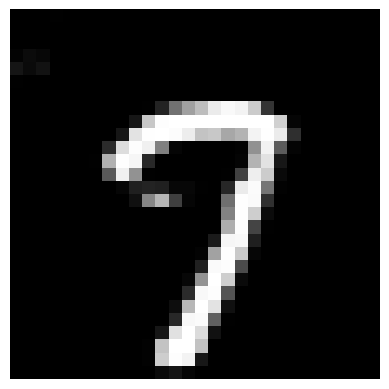

Time for epoch 27 is 30.40417766571045 sec
1/1 [==============================] - 0s 19ms/step


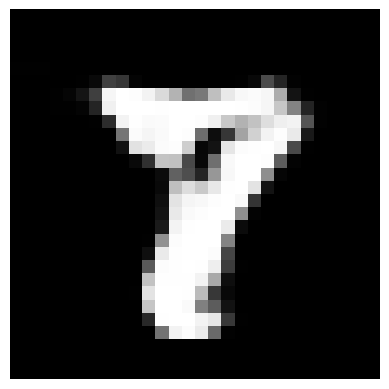

Time for epoch 28 is 30.96359419822693 sec
1/1 [==============================] - 0s 23ms/step


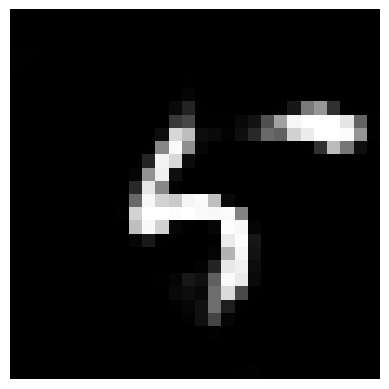

Time for epoch 29 is 25.7073495388031 sec
1/1 [==============================] - 0s 17ms/step


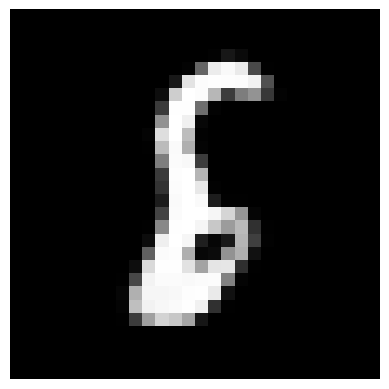

Time for epoch 30 is 24.969866514205933 sec
1/1 [==============================] - 0s 18ms/step


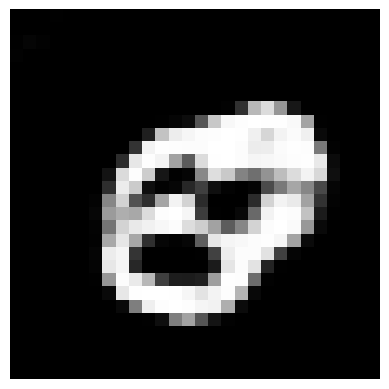

Time for epoch 31 is 25.47773575782776 sec
1/1 [==============================] - 0s 21ms/step


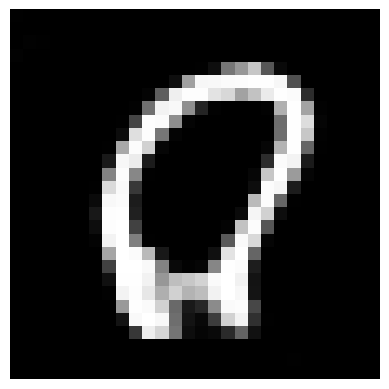

Time for epoch 32 is 25.71594524383545 sec
1/1 [==============================] - 0s 17ms/step


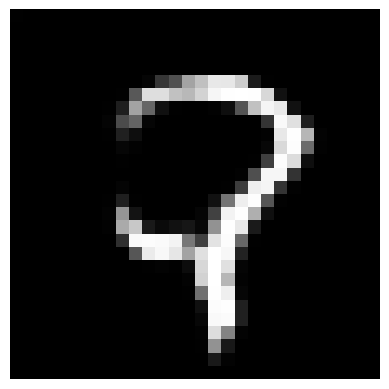

Time for epoch 33 is 24.873232126235962 sec
1/1 [==============================] - 0s 17ms/step


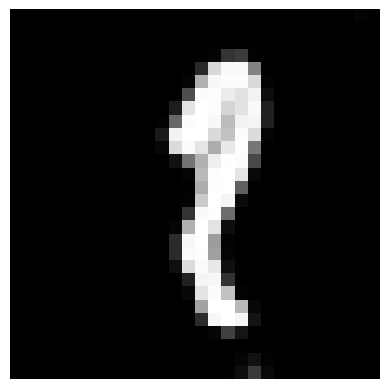

Time for epoch 34 is 27.712708711624146 sec
1/1 [==============================] - 0s 21ms/step


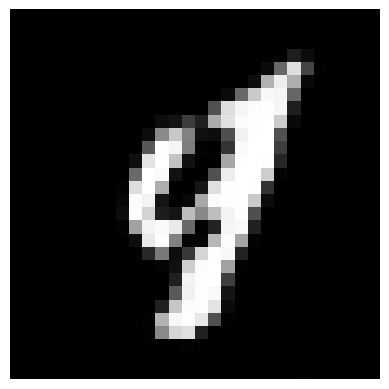

Time for epoch 35 is 28.324008226394653 sec
1/1 [==============================] - 0s 20ms/step


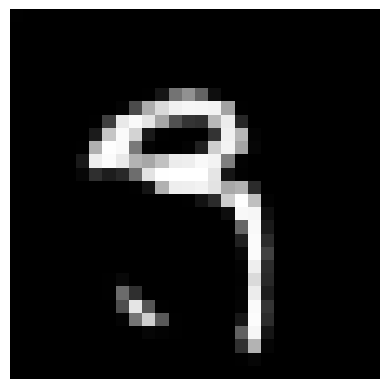

Time for epoch 36 is 33.9853892326355 sec
1/1 [==============================] - 0s 28ms/step


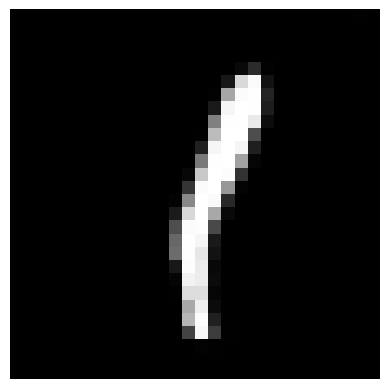

Time for epoch 37 is 34.2492139339447 sec
1/1 [==============================] - 0s 20ms/step


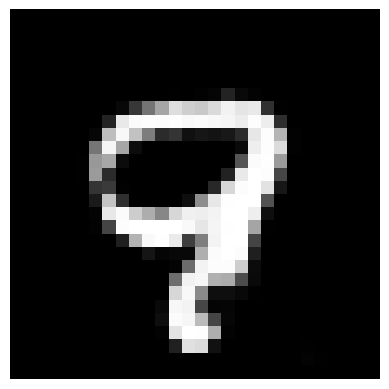

Time for epoch 38 is 35.06121897697449 sec
1/1 [==============================] - 0s 21ms/step


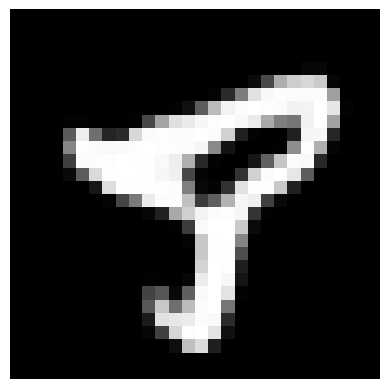

Time for epoch 39 is 33.197322845458984 sec
1/1 [==============================] - 0s 21ms/step


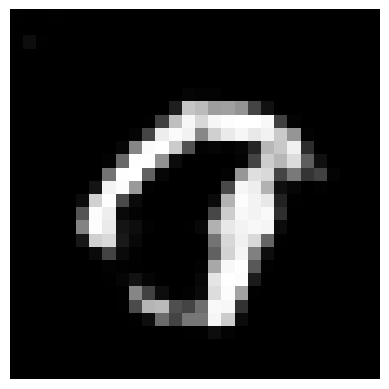

Time for epoch 40 is 33.602683544158936 sec
1/1 [==============================] - 0s 21ms/step


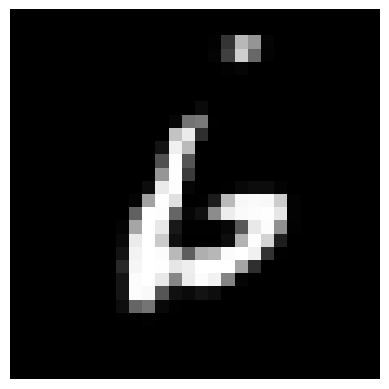

Time for epoch 41 is 34.29720759391785 sec
1/1 [==============================] - 0s 24ms/step


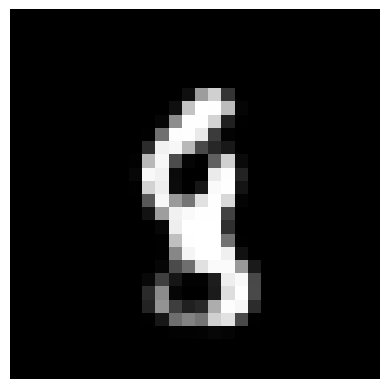

Time for epoch 42 is 34.14146661758423 sec
1/1 [==============================] - 0s 20ms/step


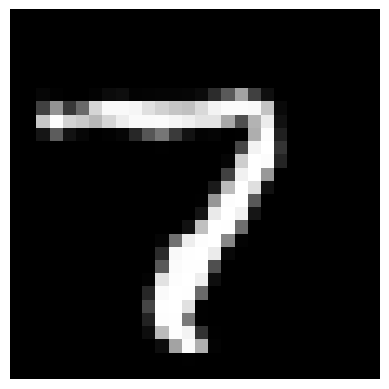

Time for epoch 43 is 33.79035544395447 sec
1/1 [==============================] - 0s 29ms/step


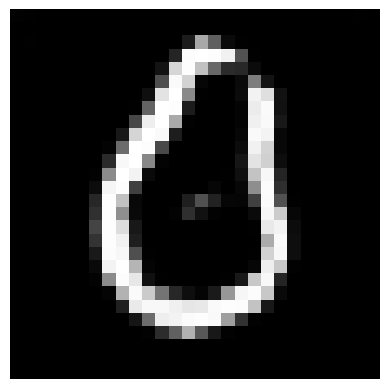

Time for epoch 44 is 33.770769357681274 sec
1/1 [==============================] - 0s 21ms/step


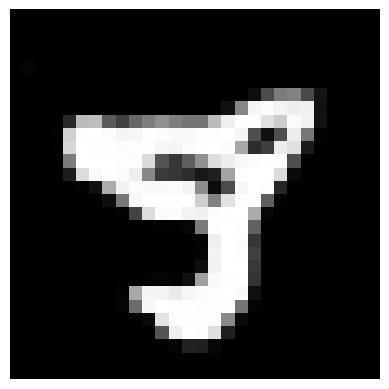

Time for epoch 45 is 34.830384969711304 sec
1/1 [==============================] - 0s 26ms/step


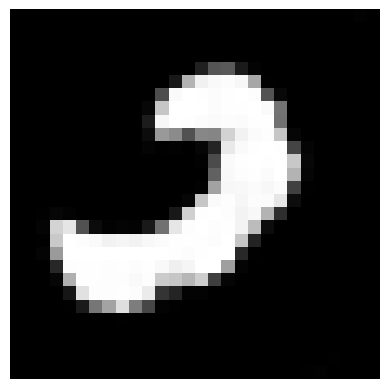

Time for epoch 46 is 34.38213300704956 sec
1/1 [==============================] - 0s 24ms/step


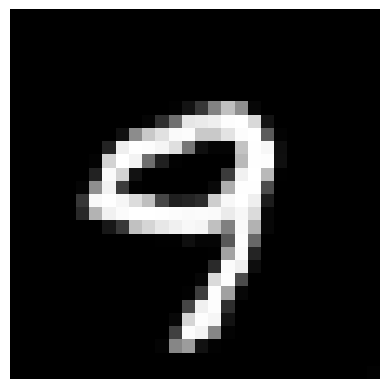

Time for epoch 47 is 33.40088987350464 sec
1/1 [==============================] - 0s 27ms/step


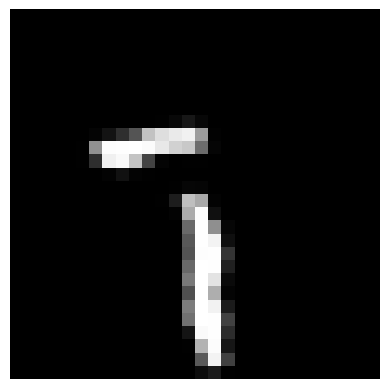

Time for epoch 48 is 33.958380699157715 sec
1/1 [==============================] - 0s 20ms/step


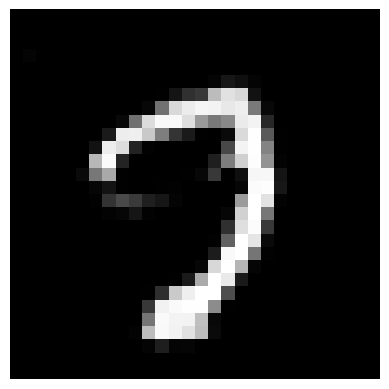

Time for epoch 49 is 34.368701457977295 sec
1/1 [==============================] - 0s 20ms/step


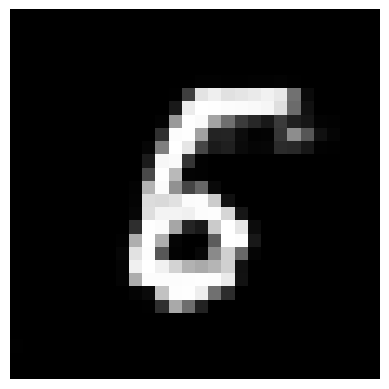

Time for epoch 50 is 32.332911252975464 sec
1/1 [==============================] - 0s 19ms/step


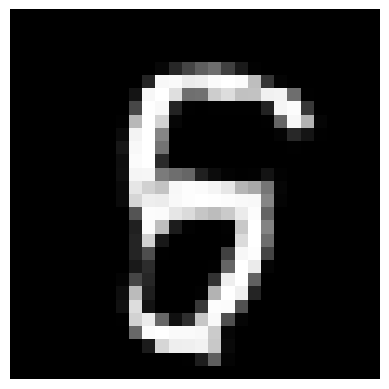

In [47]:
train(train_dataset, 50, 20)

# Tasks
Change the model architectures and try to generate as good images as possible.

Remember to not only change the generator. If the discriminator gets better, the generator need to generate better images.